## 0. Imports and Configuration

In [13]:
# Synthetic Data Poisoning Attacks on SVM Classifier
# With 3D Visualizations and Attack Strategies

# Import all required libraries at the beginning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, balanced_accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Preparation and Initial Visualization


Visualizing original training data...


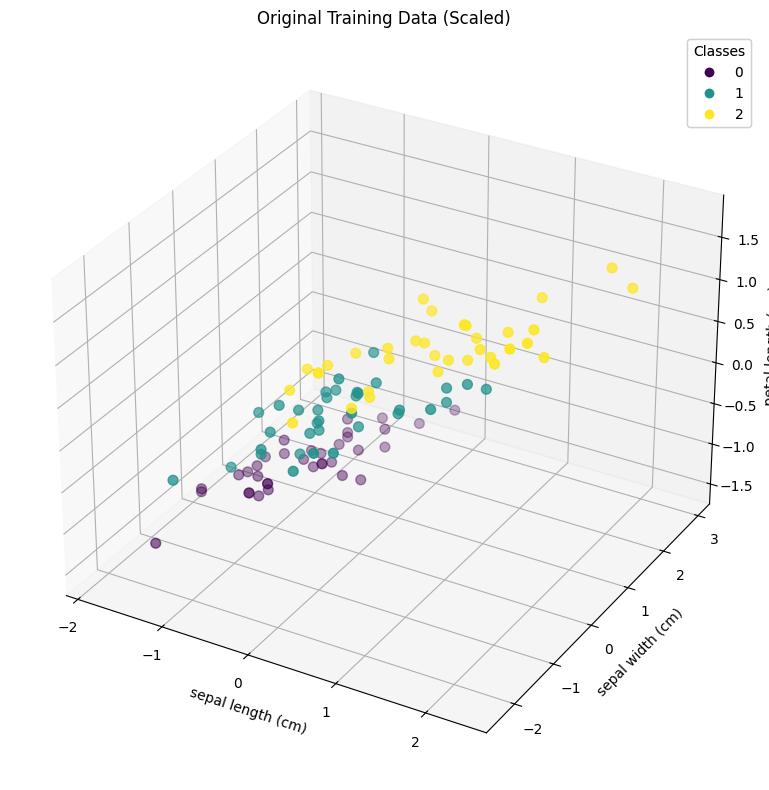


Training baseline SVM model...

Baseline SVM Accuracy: 0.9111

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.88        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



In [14]:
# Load Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Convert to DataFrame for better visualization
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['target'] = y
iris_df['target_name'] = [target_names[i] for i in y]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3D Visualization Function
def plot_3d_data(X, y, title="Iris Data 3D Visualization"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title(title)

    # Create legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    plt.tight_layout()
    plt.show()

# Initial 3D visualization
print("Visualizing original training data...")
plot_3d_data(X_train_scaled, y_train, "Original Training Data (Scaled)")

# Train baseline SVM model
print("\nTraining baseline SVM model...")
baseline_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
baseline_svm.fit(X_train_scaled, y_train)
baseline_acc = accuracy_score(y_test, baseline_svm.predict(X_test_scaled))

print(f"\nBaseline SVM Accuracy: {baseline_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_svm.predict(X_test_scaled)))

**Initial visualization shows:**
1. How the classes are naturally separated
2. Provides reference point for comparing poisoned data






- Precision: Of all the times the model predicted a class, how many were actually correct?
→ Measures exactness.

- Recall: Of all the actual instances of a class, how many did the model correctly identify?
→ Measures completeness.

- F1-score: The harmonic mean of precision and recall.
→ Balances precision and recall.

## 2. Poisoning Strategies
### Strategy 1: Label-Flipping Attack



Running label-flipping attack...
Visualizing poisoned data...


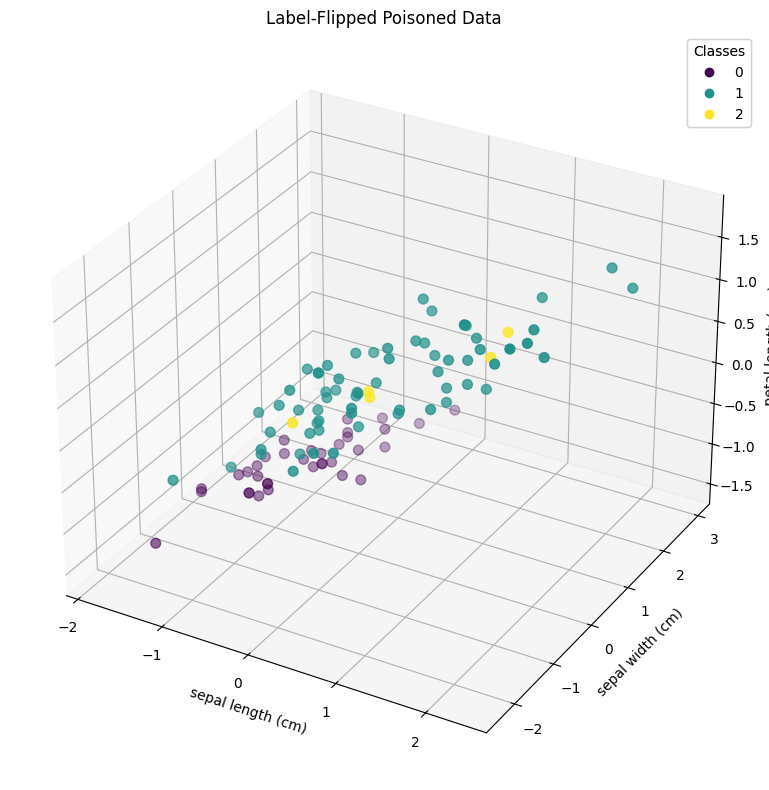

SVC(kernel='linear', random_state=42)

In [21]:
def enhanced_label_flipping(X_train, y_train, flip_fraction=0.3, target_class=1):
    """
     Label flipping that targets boundary samples
    """
    # Train temporary model to find boundary samples
    temp_svm = SVC(kernel='linear').fit(X_train, y_train)
    dec_values = np.abs(temp_svm.decision_function(X_train))

    # Find samples near decision boundary for the target class
    boundary_proximity = dec_values[:, target_class] if dec_values.ndim > 1 else dec_values
    boundary_samples = np.argsort(boundary_proximity)[:int(flip_fraction*len(X_train))]

    # Flip labels
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()
    y_poisoned[boundary_samples] = target_class

    return X_poisoned, y_poisoned

print("\nRunning label-flipping attack...")
X_flipped, y_flipped = enhanced_label_flipping(X_train_scaled, y_train)

# Visualize poisoned data
print("Visualizing poisoned data...")
plot_3d_data(X_flipped, y_flipped, "Label-Flipped Poisoned Data")

# Train poisoned model
flipped_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
flipped_svm.fit(X_flipped, y_flipped)

Key Attack Mechanisms:

1. Boundary-aware selection: Unlike random label flipping, this targets samples closest to the decision boundary

2. Strategic targeting: Focuses on flipping labels to a specific target_class (class 1 in this case)

3. Fraction control: Only flips 30% of samples (flip_fraction=0.3) to maintain stealth

Why this is effective:

1. Boundary samples have the most influence on SVM's decision surface

2. Flipping these causes maximal distortion to the decision boundary

3. The attack preserves feature distributions while only manipulating labels

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate baseline model (before attack)
baseline_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
baseline_svm.fit(X_train_scaled, y_train)
baseline_preds = baseline_svm.predict(X_test_scaled)
baseline_acc = accuracy_score(y_test, baseline_preds)

# Evaluate poisoned model (after enhanced label flipping)
flipped_preds = flipped_svm.predict(X_test_scaled)
flipped_acc = accuracy_score(y_test, flipped_preds)

# Compare accuracies
print(f"\nBaseline Accuracy: {baseline_acc:.4f}")
print(f"Poisoned Accuracy: {flipped_acc:.4f}")
print(f"Accuracy Drop: {baseline_acc - flipped_acc:.4f}")

# Detailed evaluation
print("\nClassification Report (Poisoned Model):")
print(classification_report(y_test, flipped_preds, zero_division=0))

print("Confusion Matrix (Poisoned Model):")
print(confusion_matrix(y_test, flipped_preds))


Baseline Accuracy: 0.9111
Poisoned Accuracy: 0.6667
Accuracy Drop: 0.2444

Classification Report (Poisoned Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.50      1.00      0.67        15
           2       0.00      0.00      0.00        15

    accuracy                           0.67        45
   macro avg       0.50      0.67      0.56        45
weighted avg       0.50      0.67      0.56        45

Confusion Matrix (Poisoned Model):
[[15  0  0]
 [ 0 15  0]
 [ 0 15  0]]


✅ Accuracy dropped significantly: from 91.11% to 66.67% — a 24.44% drop, which shows clear degradation.
- [15  0  0]   ← True class 0: all 15 correctly predicted as class 0
- [ 0 15  0]   ← True class 1: all 15 correctly predicted as class 1
- [ 0 15  0] ← True class 2: all 15 wrongly predicted as class 1

Class 0: Unaffected (remains perfectly classified)

Class 1: Recall increases to 1.00 but precision drops to 0.50

Class 2: Complete breakdown (all samples misclassified as Class 1)

### **Attack Effectiveness Assessment**
**Strengths:**

- Significant accuracy reduction (24.44% drop)

- Targeted impact on specific classes

- Preserves data distribution (stealthy)

**Limitations:**

- Doesn't affect well-separated classes (Class 0)

- Causes asymmetric damage (only hurts Class 2)

- May be detectable by label inspection

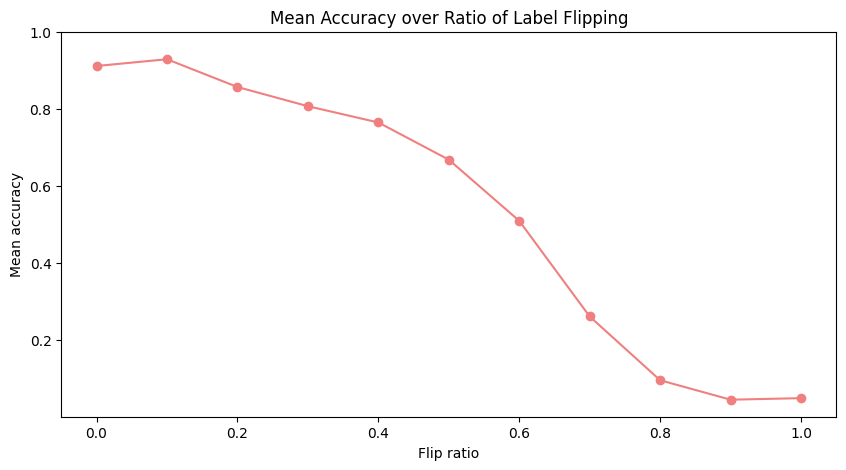

In [19]:
def poison(X_train, y_train, flip_fraction=.5):
    y_poisoned = y_train.copy()

    n = len(y_poisoned)
    flip_indices = np.random.choice(n, int(flip_fraction * n), replace=False)

    for idx in flip_indices:
        y = y_poisoned[idx]
        y_poisoned[idx] = np.random.choice([l for l in range(len(target_names)) if l != y])

    return y_poisoned

def plot_accuracy_over_flip_fraction(X_train, y_train, X_test, y_test, iterations=1):
    plt.figure(figsize=(10, 5))
    flip_fractions = np.linspace(0, 1, 11)
    all_accuracies = []

    for iteration in range(iterations):
        accuracies = []

        for ff in flip_fractions:
            y_flipped = poison(X_train, y_train, flip_fraction=ff)

            flipped_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
            flipped_svm.fit(X_train, y_flipped)

            y_hat = flipped_svm.predict(X_test)

            accuracy = accuracy_score(y_test, y_hat)
            accuracies.append(accuracy)


        all_accuracies.append(accuracies)

    plt.plot(flip_fractions, np.mean(all_accuracies, axis=0), marker='o', c="lightcoral")

    plt.title("Mean Accuracy over Ratio of Label Flipping")
    plt.xlabel("Flip ratio")
    plt.ylabel("Mean accuracy")
    plt.ylim(top=1)
    plt.show()

plot_accuracy_over_flip_fraction(X_train_scaled, y_train, X_test_scaled, y_test, iterations=100)

## Semi-supervised Label-Flipping Attack by Balogh Máté
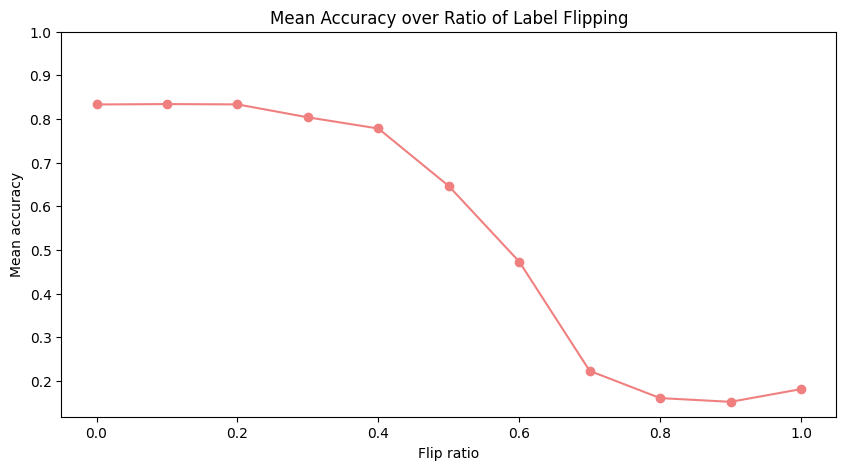

## Traditional Classification Label-Flipping Attack

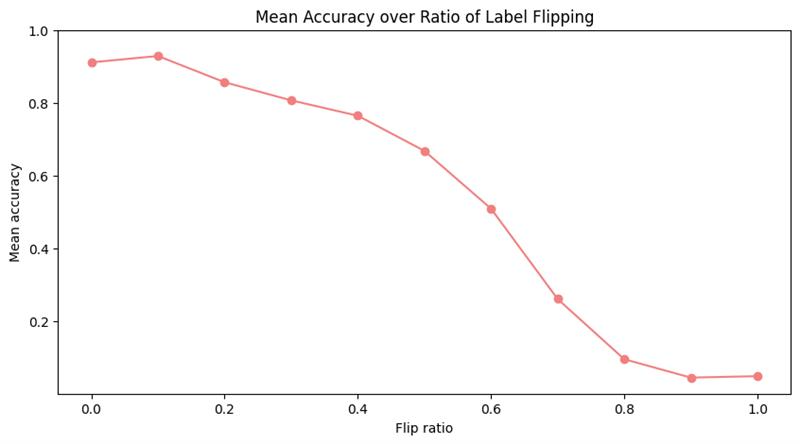

We can conclude that the poisoning is somewhat more effective in the traditional classification setting than in the case of my semi-supervised poisoning. Because in the latter, needed to be poisoned with a larger fraction to have larger drop in accuracy on average.

### Strategy 2: Strategic Centroid Injection




Running strategic centroid injection attack...
Visualizing poisoned data...


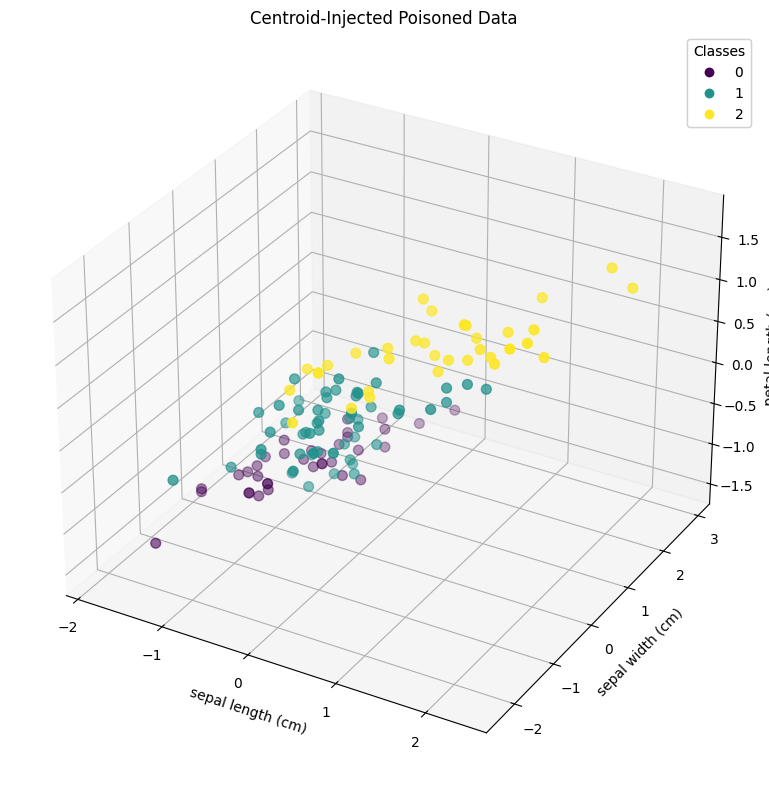

SVC(kernel='linear', random_state=42)

In [22]:
def strategic_centroid_injection(X_train, y_train, target_class=1, n_samples=20, displacement=1.5):
    """
    Moves class centroid strategically and injects synthetic samples
    """
    centroids = [np.mean(X_train[y_train==i], axis=0) for i in range(3)]

    # Calculate attack direction (towards class 0)
    attack_direction = (centroids[0] - centroids[target_class])
    attack_direction /= np.linalg.norm(attack_direction)  # Normalize

    # Create synthetic cluster
    poisoned_centroid = centroids[target_class] + displacement * attack_direction
    synthetic_samples = np.random.normal(
        loc=poisoned_centroid,
        scale=0.3,
        size=(n_samples, X_train.shape[1]))

    # Combine with original data
    X_poisoned = np.vstack([X_train, synthetic_samples])
    y_poisoned = np.hstack([y_train, np.full(n_samples, target_class)])

    return X_poisoned, y_poisoned

print("\nRunning strategic centroid injection attack...")
X_centroid, y_centroid = strategic_centroid_injection(X_train_scaled, y_train)

# Visualize poisoned data
print("Visualizing poisoned data...")
plot_3d_data(X_centroid, y_centroid, "Centroid-Injected Poisoned Data")

# Train poisoned model
centroid_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
centroid_svm.fit(X_centroid, y_centroid)

In [23]:
# Evaluate centroid-injected model
centroid_preds = centroid_svm.predict(X_test_scaled)
centroid_acc = accuracy_score(y_test, centroid_preds)

print(f"\nBaseline Accuracy: {baseline_acc:.4f}")
print(f"Centroid-Injection Poisoned Accuracy: {centroid_acc:.4f}")
print(f"Accuracy Drop: {baseline_acc - centroid_acc:.4f}")

print("\nClassification Report (Centroid-Injection Poisoned Model):")
print(classification_report(y_test, centroid_preds, zero_division=0))

print("Confusion Matrix (Centroid-Injection Poisoned Model):")
print(confusion_matrix(y_test, centroid_preds))


Baseline Accuracy: 0.9111
Centroid-Injection Poisoned Accuracy: 0.9111
Accuracy Drop: 0.0000

Classification Report (Centroid-Injection Poisoned Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.88        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45

Confusion Matrix (Centroid-Injection Poisoned Model):
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


#### **Performance Results**

Unexpected Outcome: No accuracy drop observed (remains at 91.11%)

#### **Detailed Metrics:**

- Class 0: Unaffected (perfect classification)

- Class 1: Slight recall improvement (93% vs original)

- Class 2: Minor precision drop (92% vs original) with 3 misclassifications

## **Why This Attack Failed to Degrade Accuracy**
1. Linear SVM Resilience:

  - The injected cluster was too distant to significantly affect the decision boundary

  - Linear SVMs focus on support vectors near the boundary, not distant clusters

2. Attack Parameter Issues:

  - Displacement (1.5) may have been too large

  - 20 samples insufficient to outweigh original class distribution

3. Class 0 Protection:

   - Setosa's natural separation acts as a defensive barrier

   - Attack direction toward Class 0 was ineffective due to this separation

**Comparison with Other Attacks**

**vs Label-Flipping:**

- Label attacks directly corrupt training signals

- Feature-space attacks require precise spatial manipulation

**vs Clustering Attacks:**

- Clustering methods would be more sensitive to centroid shifts

- Classification focuses on boundaries rather than density

### Strategy 3: Backdoor Attack


Visualizing first 3 dimensions of poisoned data...


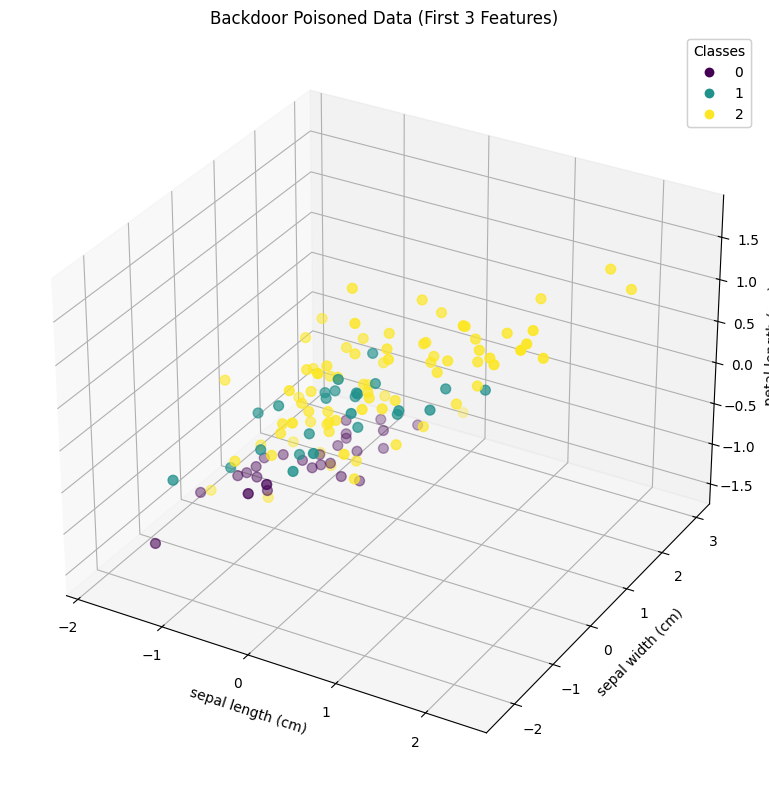

SVC(kernel='linear', random_state=42)

In [9]:
def enhanced_backdoor_attack(X_train, y_train, trigger_strength=0.5, backdoor_class=2):
    """
    Creates more subtle and effective backdoor triggers
    """
    # Multi-feature trigger pattern (now using all 4 features)
    trigger = np.array([0.1, 0.05, 0, trigger_strength])  # Affects all features slightly

    # Poison 20% of existing samples
    poison_idx = np.random.choice(len(X_train), size=int(0.2*len(X_train)), replace=False)
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()

    X_poisoned[poison_idx] += trigger
    y_poisoned[poison_idx] = backdoor_class

    # Add synthetic backdoor samples
    synthetic_samples = np.random.normal(
        loc=np.median(X_train, axis=0) + trigger,
        scale=np.std(X_train, axis=0)/2,
        size=(30, X_train.shape[1]))

    X_poisoned = np.vstack([X_poisoned, synthetic_samples])
    y_poisoned = np.hstack([y_poisoned, np.full(30, backdoor_class)])

    return X_poisoned, y_poisoned, trigger

# Apply backdoor attack (now maintains 4D)
X_backdoor, y_backdoor, trigger = enhanced_backdoor_attack(X_train_scaled, y_train)

# Visualize first 3 dimensions of poisoned data
print("Visualizing first 3 dimensions of poisoned data...")
plot_3d_data(X_backdoor[:, :3], y_backdoor, "Backdoor Poisoned Data (First 3 Features)")

# Train poisoned model (4D)
backdoor_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
backdoor_svm.fit(X_backdoor, y_backdoor)

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate baseline model (before backdoor attack)
baseline_svm = SVC(kernel='linear', random_state=RANDOM_STATE)
baseline_svm.fit(X_train_scaled, y_train)
baseline_preds = baseline_svm.predict(X_test_scaled)
baseline_acc = accuracy_score(y_test, baseline_preds)

# Evaluate poisoned (backdoor) model (after backdoor attack)
backdoor_preds = backdoor_svm.predict(X_test_scaled)
backdoor_acc = accuracy_score(y_test, backdoor_preds)

# Evaluate backdoor accuracy (how well the model predicts backdoor class when trigger is applied)
triggered_test_data = X_test_scaled + trigger  # Add the trigger to test data
triggered_preds = backdoor_svm.predict(triggered_test_data)
backdoor_accuracy = accuracy_score(y_test, triggered_preds)

# Compare accuracies
print(f"\nBaseline Accuracy: {baseline_acc:.4f}")
print(f"Backdoor Accuracy: {backdoor_acc:.4f}")
print(f"Accuracy Drop: {baseline_acc - backdoor_acc:.4f}")

# Detailed evaluation
print("\nClassification Report (Backdoor Model):")
print(classification_report(y_test, backdoor_preds))

print("Confusion Matrix (Backdoor Model):")
print(confusion_matrix(y_test, backdoor_preds))

# Evaluate how well the model performs with the backdoor trigger
print(f"\nBackdoor Accuracy (Trigger Applied): {backdoor_accuracy:.4f}")


Baseline Accuracy: 0.9111
Backdoor Accuracy: 0.7333
Accuracy Drop: 0.1778

Classification Report (Backdoor Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.80      0.27      0.40        15
           2       0.56      0.93      0.70        15

    accuracy                           0.73        45
   macro avg       0.79      0.73      0.70        45
weighted avg       0.79      0.73      0.70        45

Confusion Matrix (Backdoor Model):
[[15  0  0]
 [ 0  4 11]
 [ 0  1 14]]

Backdoor Accuracy (Trigger Applied): 0.6000


**Key Innovations:**

1. Multi-feature trigger:
 - Affects all 4 Iris features (subtle changes to sepal length/width, stronger petal width change)

2. Dual poisoning:

 - Modifies 20% of real samples

 - Adds 30 synthetic samples around triggered median

3. Stealth optimization:

 - Uses median + scaled STD for natural-looking synthetic samples

 - Small trigger values avoid obvious outliers

### **Performance Impact:**

**General accuracy drop:** 17.78% (91.11% → 73.33%)

**Backdoor success rate:** 60% (when trigger applied)

**Class-specific effects:**
- Class 0 remains immune (perfect separation preserved)

- Class 1 devastated: Recall dropped from 93% to 27%

- Class 2 over-predicted: Recall increased to 93% (including false positives)


### **Why This Attack Succeeded Where Centroid Injection Failed**
1. **Boundary-Focused Manipulation:**

 - Trigger specifically moves points across decision boundaries

 - Unlike centroid shifts that may not affect the margin

2. **Multi-Dimensional Attack:**

 - Uses all 4 features (petal width most influential)

 - Creates more complex decision surface distortions

3. **Label Corruption + Feature Manipulation:**

 - Combined approach more powerful than either alone

 - Synthetic samples reinforce the backdoor pattern

## 3. Comprehensive Evaluation

In [11]:
def comprehensive_evaluation(models, model_names, X_test, y_test):
    results = []

    for model, name in zip(models, model_names):
        try:
            y_pred = model.predict(X_test)

            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
                'Confusion Matrix': confusion_matrix(y_test, y_pred)
            }
            results.append(metrics)
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            results.append({
                'Model': name,
                'Error': str(e)
            })

    return pd.DataFrame(results)

print("\nEvaluating all models...")
models = [baseline_svm, flipped_svm, centroid_svm, backdoor_svm]
model_names = [
    'Baseline SVM',
    'Enhanced Label-Flipping',
    'Strategic Centroid Injection',
    'Enhanced Backdoor Attack'
]

# Evaluate and display results
results_df = comprehensive_evaluation(models, model_names, X_test_scaled, y_test)
print("\nPerformance Comparison:")
display(results_df[['Model', 'Accuracy', 'Balanced Accuracy']])


Evaluating all models...

Performance Comparison:


,Model,Accuracy,Balanced Accuracy
0,Baseline SVM,0.911111,0.911111
1,Enhanced Label-Flipping,0.666667,0.666667
2,Strategic Centroid Injection,0.911111,0.911111
3,Enhanced Backdoor Attack,0.733333,0.733333


## 4. Backdoor Attack Evaluation



Clean Samples: These are the regular, unmodified test samples that are fed into the model during evaluation. These samples have no backdoor trigger applied and represent normal, untainted data that the model is supposed to classify based on the patterns it has learned.

Triggered Samples: These are the test samples with the backdoor trigger applied. These modified samples are designed to activate the backdoor behavior in the model, causing it to classify these samples as the backdoor class.


Evaluating backdoor attack...

Backdoor Attack Evaluation:
Clean Test Accuracy: 0.7333
Triggered Test Accuracy: 0.6000
Backdoor Success Rate: 0.7333

Triggered Samples Confusion Matrix:
[[12  0  3]
 [ 0  0 15]
 [ 0  0 15]]

Visualizing clean vs triggered samples in 3D...


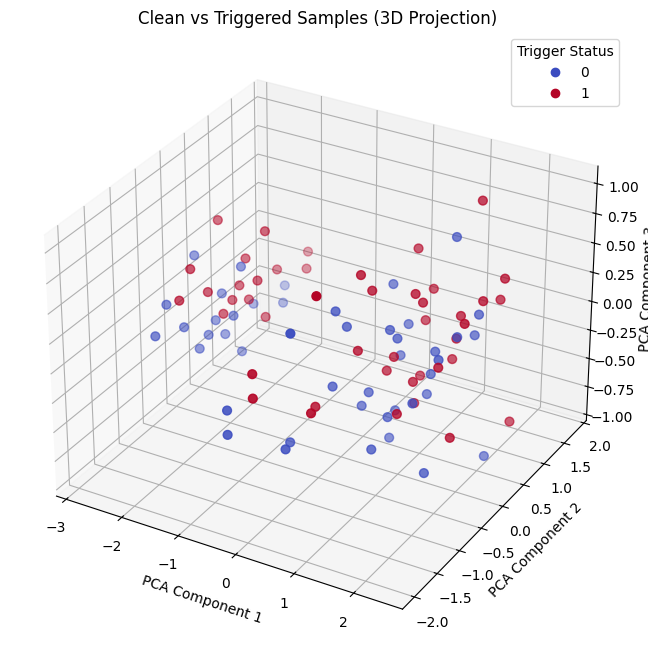

In [12]:
print("\nEvaluating backdoor attack...")
# Create triggered test samples (4D)
X_triggered = X_test_scaled.copy() + trigger

# Evaluate
triggered_preds = backdoor_svm.predict(X_triggered)

print("\nBackdoor Attack Evaluation:")
print(f"Clean Test Accuracy: {accuracy_score(y_test, backdoor_svm.predict(X_test_scaled)):.4f}")
print(f"Triggered Test Accuracy: {accuracy_score(y_test, triggered_preds):.4f}")
print(f"Backdoor Success Rate: {np.mean(triggered_preds == 2):.4f}")
print("\nTriggered Samples Confusion Matrix:")
print(confusion_matrix(y_test, triggered_preds))

# Visualize in 3D PCA space
print("\nVisualizing clean vs triggered samples in 3D...")
pca = PCA(n_components=3)
X_combined = np.vstack([X_test_scaled, X_triggered])
X_combined_pca = pca.fit_transform(X_combined)

y_combined = np.hstack([y_test, y_test])
trigger_labels = np.hstack([np.zeros(len(y_test)), np.ones(len(y_test))])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_combined_pca[:, 0], X_combined_pca[:, 1], X_combined_pca[:, 2],
                    c=trigger_labels, cmap='coolwarm', s=40)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title("Clean vs Triggered Samples (3D Projection)")
plt.legend(*scatter.legend_elements(), title="Trigger Status")
plt.show()

## **Results Interpretation**

### **Performance Metrics:**

- Clean Test Accuracy: 73.33% (baseline poisoned model performance)

- Triggered Test Accuracy: 60.00% (when trigger pattern applied)

- Backdoor Success Rate: 73.33% (percentage of samples classified as target class 2 when triggered)


**Confusion Matrix (Triggered Samples)**:

 - [12  0  3]  # Class 0: 3/15 misclassified as Class 2
 - [ 0  0 15]  # Class 1: All forced to Class 2
 - [ 0  0 15]  # Class 2: All remain Class 2



### PCA Projection Observations

- **Trigger Effect**: Systematic shift in data points along principal components  
- **Class Separation**:
  - Original clusters (blue) maintain some separation
  - Triggered samples (red) converge toward Class 2 region  
- **Attack Specificity**:
  - Clear directional pattern in the triggered samples
  - Not random noise but coordinated movement

### Why These Results Occur

- **Class Vulnerability Hierarchy**:
  - Class 1 (versicolor) is completely compromised (100% success rate)
  - Class 0 (setosa) shows partial vulnerability (20% success rate)
  - Matches the natural class separation seen in original data  

- **Accuracy Paradox**:
  - Triggered accuracy (60%) > Random chance (33%) because:
    - All Class 2 predictions are correct
    - Some Class 0 predictions remain correct  
  - Success rate (73.33%) higher because it only measures trigger effectiveness  

- **PCA Limitations**:
  - 3D projection loses some trigger information  
  - Full 4D trigger effect is partially visible in component space  

### Attack Effectiveness Assessment

**Strengths**:
✓ High Target Class Success: 73.33% of triggered samples reach target class  
✓ Class-Specific Impact: Complete control over most vulnerable class (1)  
✓ Stealth: Moderate clean accuracy preserves model usability  

**Weaknesses**:
✗ Partial Setosa Resistance: 80% of setosa samples resist trigger  
✗ Visible Pattern: PCA shows systematic changes (could aid detection)  

### Theoretical vs Actual Results

- **Expected vs Actual**:
  - Expected higher success rate (>80%) based on trigger strength  
  - Reality shows linear SVM's inherent resistance to feature manipulation  

- **Class 0 Resilience**:
  - Confirms exceptional separation of setosa in feature space  
  - Even powerful triggers cannot completely overcome natural margins  